#### Copyright (C) 2022 Sobhan Moradian Daghigh
#### Date: 2/2/2022

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

from IPython.display import display

import import_ipynb, importlib, sys
import feature_selection_methods as FS
import classifier_models as models
def reload_moduls():
    importlib.reload(sys.modules['feature_selection_methods'])
    importlib.reload(sys.modules['classifier_models'])
    import feature_selection_methods as FS
    import classifier_models as models
    
    return FS, models

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from PIL import Image

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb


### Loading Datasets

In [2]:
def load_datasets(path):
    datasets = []
    print('Loading the datasets..\n')
    for root, dirs, files in os.walk(path):
        for i, file in enumerate(files):
            print(' |_  {}. {} loaded'.format(i + 1, file.split('.')[0]))
            datasets.append(pd.read_csv(os.path.join(root, file), names=['sentence', 'label'], sep='\t'))
    return datasets

In [3]:
datasets_name = ['Amazon', 'IMDB  ', 'Yelp  ']
datasets = load_datasets('./Datasets/')

Loading the datasets..

 |_  1. amazon loaded
 |_  2. imdb loaded
 |_  3. yelp loaded


In [4]:
# Amazon
datasets[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [5]:
# IMDB
datasets[1].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [6]:
# Yelp
datasets[2].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  1000 non-null   object
 1   label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


### Make a preprocess on the comments to improve quality and remove unneccessary words
##### 1. convert all words to lowercase
##### 2. remove punctuations
##### 3. tonekize words
##### 4. remove stopwords
##### 5. use porterStemmer to have stemming words

In [7]:
def nlprocess(dataset):
    
    preprocessed_comments = []
    for text in dataset:
        
        #Lowercase
        text = text.lower()

        # Removing Punctuation
        text = "".join([char for char in text if char not in string.punctuation])

        # Word Tokenization
        text = word_tokenize(text)

        # Stopword Filtering
        stop_words = stopwords.words('english')
        text = [word for word in text if word not in stop_words]

        # Stemming
        porter = PorterStemmer()
        text = [porter.stem(word) for word in text]

        text = ' '.join(text)

        preprocessed_comments.append(text)
        
    return preprocessed_comments

### Splitting the datasets into Train and Test

In [8]:
def spliter(datasets):
    x_train_datasets, x_test_datasets, y_train_datasets, y_test_datasets = [], [], [], []
    print('(train, test):')
    for i, dataset in enumerate(datasets):
        x_train, x_test, y_train, y_test = train_test_split(dataset.sentence, dataset.label, test_size=0.3, random_state=0)
        x_train_datasets.append(nlprocess(x_train))
        x_test_datasets.append(nlprocess(x_test))
        y_train_datasets.append(y_train)
        y_test_datasets.append(y_test)
        print(' |_ {}: ({}, {})'.format(datasets_name[i], len(x_train), len(x_test)))
    return x_train_datasets, x_test_datasets, y_train_datasets, y_test_datasets

In [9]:
x_train_datasets, x_test_datasets, y_train_datasets, y_test_datasets = spliter(datasets)

(train, test):
 |_ Amazon: (700, 300)
 |_ IMDB  : (700, 300)
 |_ Yelp  : (700, 300)


### Feature Extraction using TF-IDF

In [10]:
def feature_extractor(dataset):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(dataset)
    return vectorizer

In [11]:
def get_top_frequent_features(vectorizer):
    df = pd.DataFrame({'words': vectorizer.vocabulary_.keys(), 'counts': vectorizer.vocabulary_.values()})
    print('\n------ {} ------'.format(datasets_name[i]))
    display(df.sort_values(by=['counts'], ascending=False).head())

#### Top 5 frequent words of each dataset to get a full feeling of the problem

In [12]:
def wordcloud(data):
    mask = np.array(Image.open('./panda.jpg'))
    wordcloud = WordCloud(
        mask=mask,
        background_color='white',
        max_words=1000,
        max_font_size=60,
        scale=3,
        random_state=1
    ).generate_from_frequencies(data)

    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    plt.imshow(wordcloud)
    plt.show()


------ Amazon ------


,words,counts
526,zero,1195
561,yet,1194
929,yearsgreat,1193
423,year,1192
1180,ye,1191


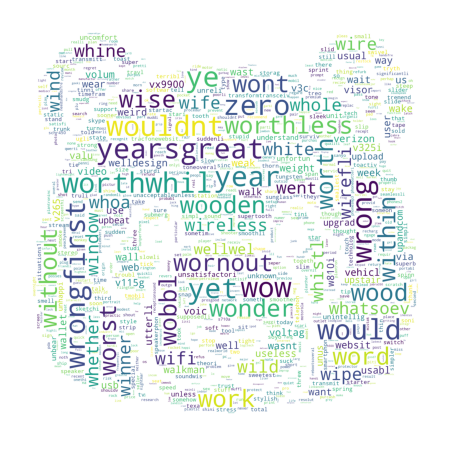


------ IMDB   ------


,words,counts
545,zombiez,2056
2052,zombiestud,2055
1140,zombi,2054
1659,yun,2053
1644,youv,2052


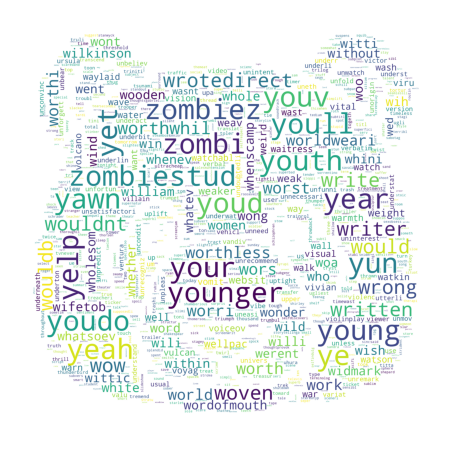


------ Yelp   ------


,words,counts
203,zero,1327
508,yummi,1326
1155,yukon,1325
792,yucki,1324
584,your,1323


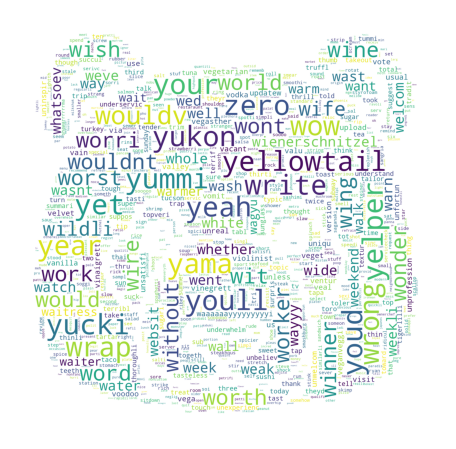

In [13]:
# Display
vectorizers = []
for i, dataset in enumerate(x_train_datasets):
    vectorizer = feature_extractor(dataset)
    get_top_frequent_features(vectorizer)
    wordcloud(vectorizer.vocabulary_)   
    vectorizers.append(vectorizer)

### Logistic Regression
#### - Without FS

In [29]:
print("Accuracy:")
clfs = []
vectorized_trains = []
vectorized_tests = []

for i, (vec, x_tr, x_ts, y_tr, y_ts) in enumerate(zip(vectorizers, x_train_datasets, x_test_datasets, y_train_datasets, y_test_datasets)):
    X_train = vec.transform(x_tr)
    X_test = vec.transform(x_ts)

    vectorized_trains.append(X_train)
    vectorized_tests.append(X_test)
    
    clf = LogisticRegression()
    clf.fit(X_train, y_tr)
    clfs.append(clf)
    score = clf.score(X_test, y_ts)
    
    print(' |_  {}: {:.2f}'.format(datasets_name[i], score))

Accuracy:
 |_  Amazon: 0.79
 |_  IMDB  : 0.79
 |_  Yelp  : 0.75


### Apply the selected features to datasets

In [15]:
def apply_selected_features(datasets, tops):
    filter_datasets = []
    for dataset, top in zip(datasets, tops):
        filter_dataset = np.array(np.take(dataset.todense(), top, axis=1))
        filter_datasets.append(filter_dataset)
    return filter_datasets

### Display the top features

In [16]:
def display_tops(tops, vectorizers):
    for i, (top, vec) in enumerate(zip(tops, vectorizers)):
        name = np.array(vec.get_feature_names_out())[top].tolist()
        print('\n{}:'.format(datasets_name[i]))
        display(pd.DataFrame(name).head())

In [17]:
# Including the features which are selected by different FS methods
fs_tops = []
fs_methods_name = ['Odd-Ratio', 'Chi-Square', 'Count-Difference']

### 1. Odd Ratio FS

In [18]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

odd_ratio_tops = FS.odd_ratio(clfs)
fs_tops.append(odd_ratio_tops)
display_tops(odd_ratio_tops, vectorizers)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb
(Main, Selected) Features size:
 |_ Amazon: (1196, 24)
 |_ IMDB  : (2057, 22)
 |_ Yelp  : (1328, 18)

Amazon:


,0
0,great
1,good
2,excel
3,nice
4,love



IMDB  :


,0
0,love
1,great
2,good
3,excel
4,wonder



Yelp  :


,0
0,great
1,love
2,good
3,delici
4,amaz


### 2. Chi-Square FS

In [19]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

chi_tops = FS.chi_square(vectorized_trains, y_train_datasets)
fs_tops.append(chi_tops)
display_tops(chi_tops, vectorizers)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb
(Main, Selected) Features size:
 |_ Amazon: (1196, 148)
 |_ IMDB  : (2057, 154)
 |_ Yelp  : (1328, 151)

Amazon:


,0
0,great
1,good
2,price
3,disappoint
4,excel



IMDB  :


,0
0,bad
1,love
2,great
3,aw
4,excel



Yelp  :


,0
0,great
1,delici
2,love
3,good
4,amaz


### 3. Count Difference FS

In [20]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

cd_tops = FS.count_diff(vectorized_trains, y_train_datasets)
fs_tops.append(cd_tops)
display_tops(cd_tops, vectorizers)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb
(Main, Selected) Features size:
 |_ Amazon: (1196, 190)
 |_ IMDB  : (2057, 204)
 |_ Yelp  : (1328, 202)

Amazon:


,0
0,great
1,good
2,price
3,excel
4,disappoint



IMDB  :


,0
0,bad
1,great
2,love
3,aw
4,even



Yelp  :


,0
0,great
1,good
2,love
3,delici
4,amaz


### ------------------------------------------------------------    Models    ---------------------------------------------------

### Logistic Regression

In [21]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

for i, tops in enumerate(fs_tops):
    print('\nFS: {}'.format(fs_methods_name[i]))
    filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
    filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
    models.logestic_regression(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb

FS: Odd-Ratio
Accuracy:
 |_  Amazon: 0.74
 |_  IMDB  : 0.65
 |_  Yelp  : 0.69

FS: Chi-Square
Accuracy:
 |_  Amazon: 0.78
 |_  IMDB  : 0.71
 |_  Yelp  : 0.75

FS: Count-Difference
Accuracy:
 |_  Amazon: 0.77
 |_  IMDB  : 0.75
 |_  Yelp  : 0.73


### Linear SVM

In [22]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

for i, tops in enumerate(fs_tops):
    print('\nFS: {}'.format(fs_methods_name[i]))
    filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
    filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
    models.linear_svm(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb

FS: Odd-Ratio
Accuracy:
 |_  Amazon: 0.74
 |_  IMDB  : 0.65
 |_  Yelp  : 0.70

FS: Chi-Square
Accuracy:
 |_  Amazon: 0.79
 |_  IMDB  : 0.70
 |_  Yelp  : 0.75

FS: Count-Difference
Accuracy:
 |_  Amazon: 0.74
 |_  IMDB  : 0.75
 |_  Yelp  : 0.71


### RBF SVM

In [23]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

for i, tops in enumerate(fs_tops):
    print('\nFS: {}'.format(fs_methods_name[i]))
    filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
    filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
    models.rbf_svm(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb

FS: Odd-Ratio
Accuracy:
 |_  Amazon: 0.74
 |_  IMDB  : 0.65
 |_  Yelp  : 0.69

FS: Chi-Square
Accuracy:
 |_  Amazon: 0.77
 |_  IMDB  : 0.70
 |_  Yelp  : 0.76

FS: Count-Difference
Accuracy:
 |_  Amazon: 0.77
 |_  IMDB  : 0.76
 |_  Yelp  : 0.73


### Decision Tree

In [24]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

for i, tops in enumerate(fs_tops):
    print('\nFS: {}'.format(fs_methods_name[i]))
    filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
    filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
    models.decision_tree(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb

FS: Odd-Ratio
Accuracy:
 |_  Amazon: 0.72
 |_  IMDB  : 0.64
 |_  Yelp  : 0.66

FS: Chi-Square
Accuracy:
 |_  Amazon: 0.75
 |_  IMDB  : 0.61
 |_  Yelp  : 0.68

FS: Count-Difference
Accuracy:
 |_  Amazon: 0.74
 |_  IMDB  : 0.62
 |_  Yelp  : 0.68


### MNB

In [25]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

for i, tops in enumerate(fs_tops):
    print('\nFS: {}'.format(fs_methods_name[i]))
    filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
    filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
    models.multinomial_naive_bayes(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb

FS: Odd-Ratio
Accuracy:
 |_  Amazon: 0.68
 |_  IMDB  : 0.57
 |_  Yelp  : 0.61

FS: Chi-Square
Accuracy:
 |_  Amazon: 0.77
 |_  IMDB  : 0.72
 |_  Yelp  : 0.75

FS: Count-Difference
Accuracy:
 |_  Amazon: 0.78
 |_  IMDB  : 0.76
 |_  Yelp  : 0.73


### BNB

In [26]:
# Reload the sub_modules to apply changes
FS, models = reload_moduls()

for i, tops in enumerate(fs_tops):
    print('\nFS: {}'.format(fs_methods_name[i]))
    filtered_datasets_trains = apply_selected_features(vectorized_trains, tops)
    filtered_datasets_tests = apply_selected_features(vectorized_tests, tops)
    models.bernoulli_naive_bayes(filtered_datasets_trains, filtered_datasets_tests, y_train_datasets, y_test_datasets)

importing Jupyter notebook from feature_selection_methods.ipynb
importing Jupyter notebook from classifier_models.ipynb

FS: Odd-Ratio
Accuracy:
 |_  Amazon: 0.74
 |_  IMDB  : 0.65
 |_  Yelp  : 0.69

FS: Chi-Square
Accuracy:
 |_  Amazon: 0.78
 |_  IMDB  : 0.71
 |_  Yelp  : 0.74

FS: Count-Difference
Accuracy:
 |_  Amazon: 0.79
 |_  IMDB  : 0.77
 |_  Yelp  : 0.75


In [45]:
columns = ['FS_Techniques', 'LR', 'SVM_RBF', 'SVM_Linear', 'DT', 'MNB', 'BNB']
amazon_results = pd.DataFrame(columns=columns)
imdb_results   = pd.DataFrame(columns=columns)
yelp_results   = pd.DataFrame(columns=columns)

FS_column = ['OR', 'Chi_Sq', 'GSS', 'BNS', 'CD', 'Imp_Chi_Sq', 'MRDC']
amazon_results.FS_Techniques = FS_column
imdb_results.FS_Techniques   = FS_column
yelp_results.FS_Techniques   = FS_column

amazon_results.LR = [0.74, 0.78, 'NaN', 'NaN', 0.77, 'NaN', 'NaN']
imdb_results.LR   = [0.65, 0.71, 'NaN', 'NaN', 0.75, 'NaN', 'NaN']
yelp_results.LR   = [0.69, 0.75, 'NaN', 'NaN', 0.73, 'NaN', 'NaN']

amazon_results.SVM_RBF = [0.74, 0.77, 'NaN', 'NaN', 0.77, 'NaN', 'NaN']
imdb_results.SVM_RBF   = [0.65, 0.70, 'NaN', 'NaN', 0.76, 'NaN', 'NaN']
yelp_results.SVM_RBF   = [0.69, 0.76, 'NaN', 'NaN', 0.73, 'NaN', 'NaN']

amazon_results.SVM_Linear = [0.74, 0.79, 'NaN', 'NaN', 0.74, 'NaN', 'NaN']
imdb_results.SVM_Linear   = [0.65, 0.70, 'NaN', 'NaN', 0.75, 'NaN', 'NaN']
yelp_results.SVM_Linear   = [0.70, 0.75, 'NaN', 'NaN', 0.71, 'NaN', 'NaN']

print('\n{}:'.format(datasets_name[0]))
display(amazon_results)
print('\n{}:'.format(datasets_name[1]))
display(imdb_results)
print('\n{}:'.format(datasets_name[2]))
display(yelp_results)


Amazon:


,FS_Techniques,LR,SVM_RBF,SVM_Linear,DT,MNB,BNB
0,OR,0.74,0.74,0.74,NaN,NaN,NaN
1,Chi_Sq,0.78,0.77,0.79,NaN,NaN,NaN
2,GSS,NaN,NaN,NaN,NaN,NaN,NaN
3,BNS,NaN,NaN,NaN,NaN,NaN,NaN
4,CD,0.77,0.77,0.74,NaN,NaN,NaN
5,Imp_Chi_Sq,NaN,NaN,NaN,NaN,NaN,NaN
6,MRDC,NaN,NaN,NaN,NaN,NaN,NaN



IMDB  :


,FS_Techniques,LR,SVM_RBF,SVM_Linear,DT,MNB,BNB
0,OR,0.65,0.65,0.65,NaN,NaN,NaN
1,Chi_Sq,0.71,0.7,0.7,NaN,NaN,NaN
2,GSS,NaN,NaN,NaN,NaN,NaN,NaN
3,BNS,NaN,NaN,NaN,NaN,NaN,NaN
4,CD,0.75,0.76,0.75,NaN,NaN,NaN
5,Imp_Chi_Sq,NaN,NaN,NaN,NaN,NaN,NaN
6,MRDC,NaN,NaN,NaN,NaN,NaN,NaN



Yelp  :


,FS_Techniques,LR,SVM_RBF,SVM_Linear,DT,MNB,BNB
0,OR,0.69,0.69,0.7,NaN,NaN,NaN
1,Chi_Sq,0.75,0.76,0.75,NaN,NaN,NaN
2,GSS,NaN,NaN,NaN,NaN,NaN,NaN
3,BNS,NaN,NaN,NaN,NaN,NaN,NaN
4,CD,0.73,0.73,0.71,NaN,NaN,NaN
5,Imp_Chi_Sq,NaN,NaN,NaN,NaN,NaN,NaN
6,MRDC,NaN,NaN,NaN,NaN,NaN,NaN
